## Preparation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.4.0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.19.2
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.4.0
tensorflow.keras 2.4.0


In [2]:
# GPU configurations
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

In [3]:
train_dir = "../datasets/10-monkeys/training/training"
valid_dir = "../datasets/10-monkeys/validation/validation"
label_file = "../datasets/10-monkeys/monkey_labels.txt"

# Need to see the file structure!
print(os.listdir(train_dir))
print(os.listdir(valid_dir))

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [4]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [5]:
# Image Scaling
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    # rescale = 1./255,  resnet50 has already done normalization!
    rotation_range = 40,
    width_shift_range = 0.2,   # percentage
    height_shift_range = 0.2,  # percentage
    shear_range = 0.2,         # shear strength
    zoom_range = 0.2,          # zoom strength
    horizontal_flip = True,
    fill_mode = "nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,                      # folder path
    target_size = (height, width),  # zoom size
    batch_size = batch_size,        # how many in one batch
    seed = 7,
    shuffle = True,
    class_mode = "categorical"      # before one_hot encode
)

Found 1098 images belonging to 10 classes.


In [6]:
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,                      # folder path
    target_size = (height, width),  # zoom size
    batch_size = batch_size,        # how many in one batch
    seed = 7,
    shuffle = False,
    class_mode = "categorical"      # before one_hot encode
)

Found 272 images belonging to 10 classes.


In [7]:
one = train_generator.next()[0]  # one batch
one.shape

(24, 224, 224, 3)

In [8]:
one[0].shape

(224, 224, 3)

In [9]:
train_num = train_generator.samples  # 1098
valid_num = valid_generator.samples  # 272

In [10]:
# Display a mini-batch of size 24
for i in range(1):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Modeling with ResNet-50

In [11]:
resnet50_fine_tune = keras.models.Sequential()
resnet50_fine_tune.add(keras.applications.ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
))
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation='softmax'))
resnet50_fine_tune.layers[0].trainable = False  # set ResNet (regarded as one layer)

resnet50_fine_tune.compile(loss="categorical_crossentropy",
                           optimizer="sgd",
                           metrics=["accuracy"])
resnet50_fine_tune.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


## Training

In [12]:
epochs = 10  # 10 for fine tune!
# fit fit_generator?
history = resnet50_fine_tune.fit(
    train_generator, 
    steps_per_epoch = train_num // batch_size,
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps = valid_num // batch_size
)

Epoch 1/10
45/45 [==============================] - 41s 636ms/step - loss: 1.6820 - accuracy: 0.4766 - val_loss: 0.3837 - val_accuracy: 0.9545
Epoch 2/10
45/45 [==============================] - 19s 420ms/step - loss: 0.3675 - accuracy: 0.9345 - val_loss: 0.2167 - val_accuracy: 0.9697
Epoch 3/10
45/45 [==============================] - 19s 426ms/step - loss: 0.2339 - accuracy: 0.9595 - val_loss: 0.1598 - val_accuracy: 0.9773
Epoch 4/10
45/45 [==============================] - 19s 426ms/step - loss: 0.1745 - accuracy: 0.9800 - val_loss: 0.1308 - val_accuracy: 0.9848
Epoch 5/10
45/45 [==============================] - 19s 424ms/step - loss: 0.1610 - accuracy: 0.9710 - val_loss: 0.1139 - val_accuracy: 0.9811
Epoch 6/10
45/45 [==============================] - 19s 419ms/step - loss: 0.1294 - accuracy: 0.9804 - val_loss: 0.1032 - val_accuracy: 0.9773
Epoch 7/10
45/45 [==============================] - 19s 421ms/step - loss: 0.1031 - accuracy: 0.9838 - val_loss: 0.0905 - val_accuracy: 0.9848

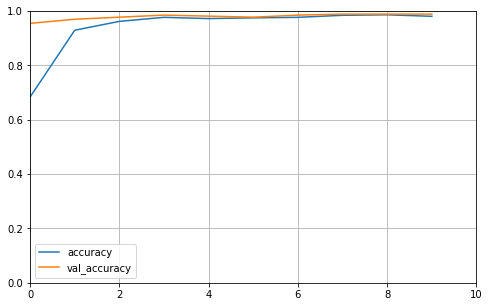

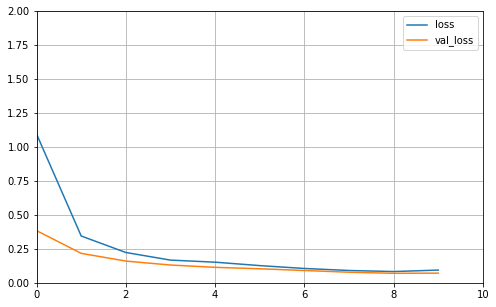

In [13]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

## ResNet-50 with last a few layers trainable

In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False,
                                       pooling="avg",
                                       weights="imagenet")
resnet50.summary()

In [ ]:
for layer in resnet50.layers[0:-5]:
    layer.trainable = False
    
resnet50_new = keras.models.Sequential([
    resnet50, keras.layers.Dense(num_classes, activation='softmax'),
])
resnet50_new.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
resnet50_new.summary()

In [ ]:
epochs = 10  # 10 for fine tune!
history = resnet_new.fit_generator(
    train_generator, 
    steps_per_epoch = train_num // batch_size,
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps = valid_num // batch_size
)